# Linear regression & RF regression & CNN regression

In [1]:
import sys
sys.path.append("../model")
from SklearnModels import Regressor

import datetime
import numpy as np
import pandas as pd
import math
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
from sklearn.metrics import r2_score

In [3]:
sys.path.append("/home/jli30/.local/lib/python3.9/site-packages")
from plotnine import *

#### Load data

In [8]:
# read in training samples
file = '../../data/2006NDVI_LCin_all.csv'
mydata = pd.read_csv(file, index_col=0)

# replace NA with 0
cmydata = mydata.fillna(0.0)

# drop rows where uvi == 0
mmidat = cmydata[cmydata.uvi != 0.0].reset_index(drop=True)


# split into train & test sets
test_ratio = 0.2
train, test = train_test_split(mmidat, test_size=test_ratio, random_state=12)
# split dependent(Y) and indenpendent(X) variable
d_var = 'uvi'
ind_vars = ['upre', 'upvi', 'u2pvi', 'u3pvi', 'u4pvi', 'u5pvi']
xTrain, yTrain = train[ind_vars], train[d_var] 
xTest, yTest = test[ind_vars],test[d_var]

# generate subset
train_subset = train.sample(frac=0.1)
train_subset.shape
xTrain_sub, yTrain_sub = train_subset[ind_vars], train_subset[d_var]

/att/gpfsfs/home/appmgr/app/jupyterhub/ilab/ilab-kernel/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [9]:
xTrain_sub.shape

(618515, 6)

#### utils

In [10]:
def relabel_ulc(df):
    if not type(df.ulc.iloc[0]) is int:
        df.ulc.astype(int)
    conditions = [
        df['ulc'] == 0,
        df['ulc'] == 10,
        df['ulc'] == 16,
        df['ulc'] == 7,
        df['ulc'] == 17,
        df['ulc'] == 12,
        df['ulc'] == 11,
        df['ulc'] == 13,
        df['ulc'] == 9,
        ]
    outputs = ['no data', 'grassland', 'barren', 'open shrbland', 'water', 'croplands', 'permanent wetlands', 'urban', 'savanna']
    return np.select(conditions, outputs,'other')

### a) Train Linear model

In [11]:
# initialize regression model
lm = Regressor("linear")

In [12]:
%%time
####start training
lm=lm.train(xTrain, yTrain, 'linear_test.joblib')
print(lm)

LinearRegression()
CPU times: user 2.65 s, sys: 9.52 s, total: 12.2 s
Wall time: 1.31 s


In [19]:
# load pre-trained model
#lm = lm._load_model("linear_test.joblib")

In [13]:
# make prediction
yPred = lm.predict(xTest)

In [14]:
r2 = r2_score(yTest, yPred)
r2 = np.round(r2, 3)
print("R^2 for testing-set ", r2)

R^2 for testing-set  0.698


#### vis
Plot predictions for test set

In [35]:
lc_type = relabel_ulc(test)
df_plot = pd.DataFrame()

In [36]:
df_plot['observations'] = yTest.values

In [37]:
df_plot['lc_type'] = lc_type
df_plot['prediction'] = yPred

In [38]:
#clean no-data 
df_plot = df_plot[df_plot.lc_type != "no data"]

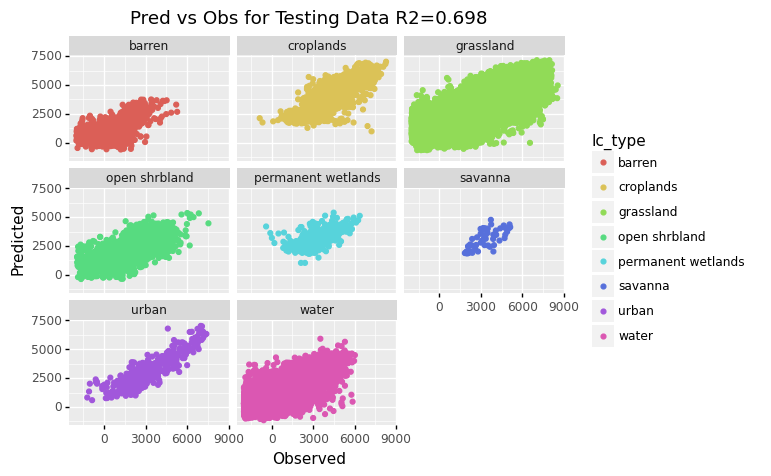

<ggplot: (2935705158413)>

In [39]:
(
    ggplot(df_plot)  # What data to use
    + aes(x="observations", y="prediction", color="lc_type")  # What variable to use
    + geom_point()  # Geometric object to use for drawing
    + xlab("Observed") + ylab("Predicted") + labs(title=f"Pred vs Obs for Testing Data R2={r2}")
    + facet_wrap(['lc_type'])
)

### b) Train RF model

In [15]:
# initialize regression model
# specify hyperparameter through dictioary
# select model type: "linear", "randomforest"

rf_params = dict(n_estimators=20, random_state=0, n_jobs=-1)
model = Regressor("randomforest", **rf_params)

In [17]:
%%time
rfm = model.train(xTrain_sub, yTrain_sub, "rf_test.joblib")
print(rfm)

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=0)
CPU times: user 1min 36s, sys: 1.06 s, total: 1min 37s
Wall time: 9.09 s


In [43]:
# Load pre-trained model
#rfm = model._load_model("rf_test.joblib")

In [46]:
yPred = rfm.predict(xTest)

/att/gpfsfs/home/appmgr/app/jupyterhub/ilab/ilab-kernel/lib/python3.7/site-packages/sklearn/base.py:435: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names


In [47]:
r2 = r2_score(yTest, yPred)
r2 = np.round(r2, 3)
print("R^2 for testing-set ", r2)

R^2 for testing-set  0.785


#### vis
Plot predictions for test set

In [48]:
lc_type = relabel_ulc(test)
df_plot = pd.DataFrame()

In [49]:
df_plot['observations'] = yTest.values
df_plot['lc_type'] = lc_type
df_plot['prediction'] = yPred

In [50]:
#clean no-data 
df_plot = df_plot[df_plot.lc_type != "no data"]

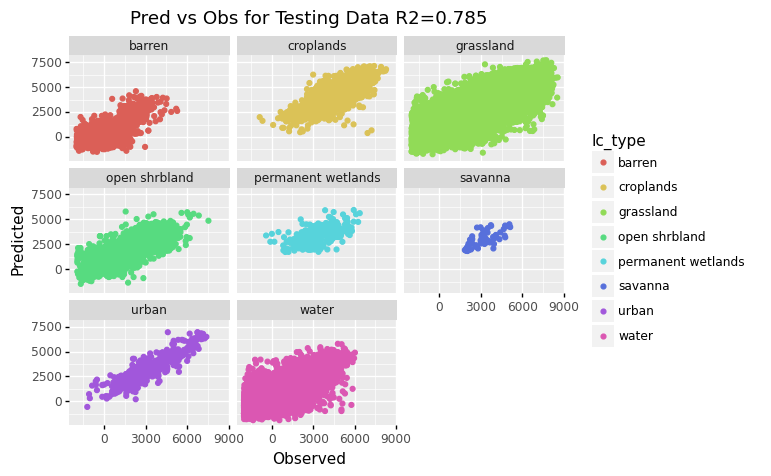

<ggplot: (2935731508317)>

In [51]:
(
    ggplot(df_plot)  # What data to use
    + aes(x="observations", y="prediction", color="lc_type")  # What variable to use
    + geom_point()  # Geometric object to use for drawing
    + xlab("Observed") + ylab("Predicted") + labs(title=f"Pred vs Obs for Testing Data R2={r2}")
    + facet_wrap(['lc_type'])
)

### c) Train CNN model

In [9]:
import torch
from model.LSTMModel import Net

In [18]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
x, y = xTrain_sub.to_numpy(), yTrain_sub.to_numpy()

x = x.reshape(x.shape[0], 1, x.shape[1])
x.shape, y.shape

((618515, 1, 6), (618515,))

In [10]:
# numpy array to pytorch tensor
x_train_ts = torch.from_numpy(x).type(torch.float32)
y_train_ts = torch.from_numpy(y).type(torch.float32)

In [19]:
net = Net()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [12]:
## Start training
import torch.utils.data as Data
from torch.autograd import Variable

In [23]:
##
BATCH_SIZE = 128
EPOCH = 10

torch_dataset = Data.TensorDataset(x_train_ts, y_train_ts)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

In [24]:
for epoch in range(EPOCH):
    epoch_loss = 0
    net = net.train()
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x).to(device)
        b_y = Variable(batch_y).to(device)
        
        prediction = net(b_x)
        loss = loss_func(prediction, b_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+0:03}: | Train Loss: {epoch_loss/len(loader):.5f}') 

Epoch 000: | Train Loss: 893035.91462
Epoch 001: | Train Loss: 892985.73921
Epoch 002: | Train Loss: 892881.48704
Epoch 003: | Train Loss: 893247.06059
Epoch 004: | Train Loss: 892769.08565
Epoch 005: | Train Loss: 893110.90392
Epoch 006: | Train Loss: 892867.29052
Epoch 007: | Train Loss: 892517.38937
Epoch 008: | Train Loss: 892715.85641
Epoch 009: | Train Loss: 892888.85819


In [25]:
torch.save(net, 'cnn_checkpoint.chk')

In [26]:
##model = torch.load('cnn_checkpoint.chk')
##model = model.eval()

In [30]:

pred = net(x_train_ts.to(device))

In [31]:
pred

tensor([[2225.3396],
        [2225.3396],
        [2225.3396],
        ...,
        [2225.3396],
        [2225.3396],
        [2225.3396]], device='cuda:0', grad_fn=<AddmmBackward>)

In [32]:
y_train_ts

tensor([1505., 2121., 2980.,  ..., 1583., 1710., 1738.])

In [33]:
x_train_ts

tensor([[[6.8611e-01, 1.8470e+03, 2.1180e+03, 1.7050e+03, 1.8390e+03,
          1.6140e+03]],

        [[1.4359e-01, 2.0250e+03, 1.6710e+03, 1.8700e+03, 1.9520e+03,
          2.1630e+03]],

        [[6.9535e+01, 3.0080e+03, 2.1590e+03, 2.5430e+03, 2.2460e+03,
          1.9800e+03]],

        ...,

        [[1.5060e-01, 2.3380e+03, 1.8960e+03, 2.1510e+03, 2.0590e+03,
          2.1990e+03]],

        [[2.9097e-01, 1.5690e+03, 1.8140e+03, 1.4960e+03, 2.1060e+03,
          1.5250e+03]],

        [[0.0000e+00, 1.6750e+03, 1.7990e+03, 1.6040e+03, 1.6650e+03,
          1.5750e+03]]])

#### Note:
1) Training is slow... even with GPU </br>
2) Model doesn't converge ...
3) Prediction becomes constant values ...
4) model architecture needs improve (why need conv1D across features??) & input data need scale and/or cleaning up
5) TBD
